<a href="https://colab.research.google.com/github/milind-nair/toxic_tweet_detection/blob/main/SIN_JCOMP_R3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Downloading classes

#CLASSIFIER

In [ ]:
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore",category=FutureWarning)
warnings.filterwarnings("ignore",category=Warning)
import imp 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np

class Classifier:
    
    def __init__(self,type,params={}):
        __classifers__ = {
        'KNN': KNeighborsClassifier,
        'M-NaiveBayes': MultinomialNB,
        'G-NaiveBayes':GaussianNB,
        'SVC': SVC,
        'DecisionTree': DecisionTreeClassifier,
        'RandomForest': RandomForestClassifier,
        'LogisticRegression': LogisticRegression,
        'MLP': MLPClassifier,
        'AdaBoost': AdaBoostClassifier,
        'Bagging': BaggingClassifier
        }
        if type not in __classifers__.keys():
            raise Exception('Available Classifiers: ',__classifers__.keys())
        self.classifier = __classifers__[type]
        self.params = params
        self.model = self.classifier(**self.params)   

    def fit(self,tr_data,tr_labels):
        return self.model.fit(tr_data,tr_labels)

    def predict(self,tst_data):
        return self.model.predict(tst_data)

    def score(self,tst_data,tst_labels):
        return self.model.score(tst_data,tst_labels)

    def tune(self,tr_data,tr_labels,tune_params=None,best_only=False,scoring='f1'):
        if not tune_params:
            tune_params = self.params
        tuner = GridSearchCV(self.model,tune_params,n_jobs=4,verbose=1,scoring=scoring)
        tuner.fit(tr_data,tr_labels)
        self.model = tuner.best_estimator_
        if best_only:
            return {'score':tuner.best_score_,'parmas':tuner.best_params_}
        else:
            param_scores = {}
            results = tuner.cv_results_
            for i,param in enumerate(tuner.cv_results_['params']):
                param_str  = ', '.join("{!s}={!r}".format(key,val) for (key,val) in param.items())
                param_scores[param_str]={'test_score':results['mean_test_score'][i],'train_score':results['mean_train_score'][i]}
            return param_scores
    
    def get_model(self):
        if getattr(self,'model',None):
            return self.model
        else:
            raise Exception('Model has not been created yet.')

    def test_and_plot(self,tst_data,tst_labels,class_num=2):
        tst_data = np.array(tst_data)
        tst_labels = np.array(tst_labels).reshape(-1,1)
        predicted_tst_labels = self.model.predict(tst_data)
        conf = np.zeros([class_num,class_num])
        confnorm = np.zeros([class_num,class_num])
        for i in range(0,tst_data.shape[0]):
            j = tst_labels[i,:]
            k = predicted_tst_labels[i]
            conf[j,k] = conf[j,k] + 1
        for i in range(0,class_num):
            confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
        self._confusion_matrix(confnorm, labels=[i for i in range(class_num)])
        return self.model.score(tst_data,tst_labels)

    def _confusion_matrix(self,cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(labels))
        plt.xticks(tick_marks, labels, rotation=45)
        plt.yticks(tick_marks, labels)
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()        
        


#PREPROCESSOR

In [ ]:
import numpy as np
import copy
from tqdm import tqdm
import imp
import warnings 
import nltk
nltk.download('punkt')
warnings.filterwarnings("ignore", category=DeprecationWarning)
class Preprocessor:

    def __init__(self,*args):
        self.params =[]
        if args:
            if isinstance(args[0],tuple):
                self.params = list(*args)
            else:
                self.params = list(args)
        self.params = ['tokenize']+self.params

    def tokenize(self):
        from nltk import word_tokenize
        for i,tweet in tqdm(enumerate(self.data),'Tokenization'):
            self.data[i] = word_tokenize(tweet.lower())
        return self.data

    def remove_stopwords(self):
        from nltk.corpus import stopwords
        import re
        stop = set(stopwords.words("english"))
        noise = ['user']
        for i,tweet in tqdm(enumerate(self.data),'Stopwords Removal'):
            self.data[i] = [w for w in tweet if w not in stop and not re.match(r"[^a-zA-Z\d\s]+", w) and w not in noise]
        return self.data
    
    def get_pos(self, word):
        from nltk import pos_tag
        from nltk.corpus import wordnet
        tag = pos_tag([word])[0][1]
        if tag.startswith('J'):
            return wordnet.ADJ
        elif tag.startswith('V'):
            return wordnet.VERB
        elif tag.startswith('N'):
            return wordnet.NOUN
        elif tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN

    def lemmatize(self):
        from nltk.stem import WordNetLemmatizer
        wnl = WordNetLemmatizer()
        for i, tweet in tqdm(enumerate(self.data),'Lemmatization'):
            for j, word in enumerate(tweet):
                self.data[i][j] = wnl.lemmatize(word, pos=self.get_pos(word))
        return self.data
    
    def stem(self):
        from nltk.stem import PorterStemmer
        stemmer = PorterStemmer()
        for i,tweet in tqdm(enumerate(self.data),'Stemming'):
            for j,word in enumerate(tweet):
                self.data[i][j] = stemmer.stem(word)
        return self.data
    
    def word_cloud(self,labels=None,filter=None):
        if not isinstance(self.data[0],list):
            raise Exception('Data must be tokenized before using word cloud.')
        import matplotlib.pyplot as plt
        from wordcloud import WordCloud
        filters = ['NOT','UNT','TIN','GRP','OTH','OFF']
        if not filter:
            plot_data = [w for i,tweet in enumerate(self.data) for w in tweet]
        else:
            if not labels:
                raise Exception('Labels must be provided for filtering text.')
            filter = filters.index(filter)
            if filter == 4:
                plot_data = [w for i,tweet in enumerate(self.data) for w in tweet if labels[i] >0]
            else:
                plot_data = [w for i,tweet in enumerate(self.data) for w in tweet if labels[i]==filter]
        all_words = ' '.join(plot_data)
        wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
        plt.figure(figsize=(10, 7))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis('off')
        plt.show()

    def clean(self, data):
        self.data = copy.deepcopy(data)
        for param in tqdm(self.params,'Preprocessing'):
            clean_call = getattr(self, param,None)
            if clean_call:
                clean_call()
            else:
                raise Exception(str(param)+' is not an available function')
        return self.data

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#DATAREADER

In [ ]:
import numpy as np
import csv
from tqdm import tqdm
from sklearn.utils import shuffle

class DataReader:

    def __init__(self,file_path,sub_task=None):
        self.file_path = file_path
        self.sub_task = sub_task

    def get_labelled_data(self):
        data = []
        labels = []
        with open(self.file_path,encoding='utf8') as tsvfile:
            reader = csv.reader(tsvfile, delimiter='\t')
            for i,line in enumerate(tqdm(reader,'Reading Data')):
                if i is 0:
                    continue
                label = self.str_to_label(line[-3:])
                if  self.sub_task:
                    self.filter_subtask(data,labels,line[1],label)
                else:
                    labels.append(label)
                    data.append(line[1])
        return data,labels
    
    def get_test_data(self):
        data = []
        ids = []
        with open(self.file_path,encoding='utf8') as tsvfile:
            reader = csv.reader(tsvfile, delimiter='\t')
            for i,line in enumerate(tqdm(reader,'Reading Test Data')):
                if i is 0:
                    continue
                ids.append(line[0])
                data.append(line[1])
        return data,ids

    def shuffle(self,data,labels,state=None):
        if not state:
            if not self.sub_task or self.sub_task == 'A':
                off_data,off_labels = [],[]
                not_data,not_labels = [],[]
                for i,tweet in tqdm(enumerate(data),'Shuffling Data'):
                    if labels[i] == 0:
                        not_data.append(tweet)
                        not_labels.append(labels[i])
                    else:
                        off_data.append(tweet)
                        off_labels.append(labels[i])
                shuffled_data = off_data[:len(off_data)//4]+not_data[:len(not_data)//4]+off_data[len(off_data)//4:len(off_data)//2]+not_data[len(not_data)//4:len(not_data)//2]+off_data[len(off_data)//2:3*len(off_data)//4]+not_data[len(not_data)//2:3*len(not_data)//4]+off_data[3*len(off_data)//4:]+not_data[3*len(not_data)//4:]
                shuffled_labels = off_labels[:len(off_labels)//4]+not_labels[:len(not_labels)//4]+off_labels[len(off_labels)//4:len(off_labels)//2]+not_labels[len(not_labels)//4:len(not_labels)//2]+off_labels[len(off_labels)//2:3*len(off_labels)//4]+not_labels[len(not_labels)//2:3*len(not_labels)//4]+off_labels[3*len(off_labels)//4:]+not_labels[3*len(not_labels)//4:]
                return shuffled_data,shuffled_labels
            elif self.sub_task in ['B','C']:
                pass
        elif state == 'random':
            shuffled_data, shuffled_labels = shuffle(data, labels, random_state=7)
            return shuffled_data,shuffled_labels
        else:
            return data,labels
        
    def upsample(self,data,labels,label=0):
        new_data = []
        new_labels = []
        count = 0 
        for i,tweet in enumerate(data):
            new_labels.append(labels[i])
            new_data.append(data[i])
            if labels[i] == label:
                new_labels.append(labels[i])
                new_data.append(data[i])
                count+=1
        return new_data,new_labels
    
    def str_to_label(self,all_labels):
        label = 0
        if all_labels[0] == 'OFF':
            if all_labels[1] == 'UNT':
                label = 1
            elif all_labels[1] == 'TIN':
                if all_labels[2] == 'IND':
                    label = 2
                elif all_labels[2] == 'GRP':
                    label = 3
                elif all_labels[2] =='OTH':
                    label = 4
        return label
    
    def filter_subtask(self,data,labels,sample,label):
        if self.sub_task == 'A':
            data.append(sample)
            labels.append(int(label>0))
        elif self.sub_task =='B':
            if label > 0:
                data.append(sample)
                labels.append(int(label>1))
        elif self.sub_task == 'C':
            if label > 1:
                data.append(sample)
                labels.append(label-2)
        


#0 - Not offensive
#1 - Offensive untargeted
#2 - Offensive targeted indiviualds
#3 - Offensive targeted groups 
#4 - Offensive targeted others

#DEEPLEARNER

In [ ]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
from tensorflow.keras.layers import Input, Dense, Embedding, Convolution1D, MaxPooling1D, MaxPooling2D, Convolution2D, LSTM
from tensorflow.keras.layers import Reshape, Flatten, Dropout, Concatenate
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences

class DeepLearner:

    def __init__(self,data,labels,vocab_length=0,model_type='LSTM'):
        self.tr_data, self.val_data, tr_labels, val_labels = train_test_split(np.array(data),labels, test_size=0.35,stratify=labels)
        self.tr_labels = self.one_hot(tr_labels)
        self.val_labels = self.one_hot(val_labels)
        self.vocab_length = vocab_length
        self.max_len = max(len(max(self.tr_data,key=lambda x:len(x))),len(max(self.val_data,key=lambda x:len(x))))
        self.tr_data = self.encode_corpus(self.tr_data)
        self.val_data = self.encode_corpus(self.val_data)
        self.model_type = model_type
        model_call = getattr(self,model_type,None)
        if model_call:
            model_call()
        else:
            raise Exception('No such model.')

    def one_hot(self,labels):
        from sklearn.preprocessing import OneHotEncoder
        encoder = OneHotEncoder()
        return encoder.fit_transform(np.array(labels).reshape(-1,1)).toarray()
    
    def CNN(self):
        model = Sequential()
        model.add(Embedding(self.vocab_length, 30, input_length=self.max_len))
        model.add(Convolution1D(64,5,activation="relu"))
        model.add(Dropout(0.5))
        model.add(Convolution1D(32,3,activation="relu"))
        model.add(Dropout(0.5))
        model.add(Convolution1D(16,3,activation="sigmoid"))
        model.add(MaxPooling1D(5))
        model.add(Flatten())
        model.add(Dense(self.tr_labels.shape[1],activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
        model.summary()
        self.model = model
    
    def CNN_2D(self):
        model = Sequential()
        model.add(Embedding(self.vocab_length, 30, input_length=self.max_len))
        model.add(Reshape((30,self.max_len,1)))
        model.add(Convolution2D(32,(1,5),activation="relu"))
        model.add(Dropout(0.9))
        model.add(Convolution2D(16,(2,3),activation="relu"))
        model.add(Dropout(0.8))
        model.add(Convolution2D(16,(2,2),activation="relu"))
        model.add(Dropout(0.7))
        model.add(Flatten())
        model.add(Dense(self.tr_labels.shape[1],activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
        model.summary()
        self.model = model

    def LSTM(self):
        model = Sequential()
        model.add(Embedding(self.vocab_length, 30, input_length=self.max_len))
        model.add(LSTM(200))
        model.add(Dense(self.max_len, activation='relu', kernel_regularizer=l2(0.90)))
        model.add(Dense(self.tr_labels.shape[1], activation='softmax', kernel_regularizer=l2(0.1)))
        adam_1 = Adam(lr=0.008)
        model.compile(loss='categorical_crossentropy', optimizer=adam_1,metrics=['accuracy'])
        model.summary()
        self.model = model
    
    def visualize(self):
        from tensorflow.keras.utils import plot_model
        plot_model(self.model,show_layer_names=False,show_shapes=True, to_file='/content/drive/MyDrive/docs/'+str(self.model_type)+'.png')
    
    def encode_corpus(self,data):
        encoded_docs = [one_hot(' '.join(d), self.vocab_length) for d in data]
        return pad_sequences(encoded_docs, maxlen=self.max_len, padding='post')

    def train(self,epochs=100,batch_size=64):
        self.model.fit(self.tr_data, self.tr_labels, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(self.val_data, self.val_labels))  # starts training

    def test(self,tst_data,tst_labels):
        tst_data = self.encode_corpus(tst_data)
        tst_labels = self.one_hot(tst_labels)
        return self.model.metrics_names,self.model.evaluate(tst_data, tst_labels, batch_size=64, verbose=1)
          
    def test_and_plot(self,tst_data,tst_labels,class_num=2):
        tst_data = self.encode_corpus(tst_data)
        tst_labels = self.one_hot(tst_labels)
        predicted_tst_labels = self.model.predict(tst_data,batch_size=64)
        conf = np.zeros([class_num,class_num])
        confnorm = np.zeros([class_num,class_num])
        for i in range(0,tst_data.shape[0]):
            j = np.argmax(tst_labels[i,:])
            k = np.argmax(predicted_tst_labels[i])
            conf[j,k] = conf[j,k] + 1
        for i in range(0,class_num):
            confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
        self._confusion_matrix(confnorm, labels=[i for i in range(class_num)])
        return self.model.metrics_names,self.model.evaluate(tst_data, tst_labels, batch_size=64, verbose=1)

    def _confusion_matrix(self,cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(labels))
        plt.xticks(tick_marks, labels, rotation=45)
        plt.yticks(tick_marks, labels)
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()     

#VECTORIZER

In [ ]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
warnings.filterwarnings('ignore', category=DeprecationWarning)
import numpy as np
from gensim.models import Word2Vec,FastText,KeyedVectors
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import gensim.downloader as api
from tqdm import tqdm
from os import listdir

class Vectorizer:
    
    def __init__(self,type,pre_trained=False,retrain=False,extend_training=False,params={}):
        self.type = type
        self.pre_trained = pre_trained
        self.params = params
        self.retrain = retrain
        self.extend_training = extend_training
        self.vectorizer = None
        self.max_len = None

    def word2vec(self):
        if not self.pre_trained:
            if 'word2vec.model' not in listdir('/content/drive/MyDrive/embeddings') or self.retrain:
                print('\nTraining Word2Vec model...')
                model = self.train_w2v()
            elif self.extend_training and 'word2vec.model' in listdir('/content/drive/MyDrive/embeddings'):
                print('\nExtending existing Word2Vec model...')
                model = Word2Vec.load("/content/drive/MyDrive/embeddings/word2vec.model")
                model.train(self.data, total_examples=len(self.data), epochs=5000)
                model.save("/content/drive/MyDrive/embeddings/word2vec.model")
            else:
                print('\nLoading existing Word2Vec model...')
                model = Word2Vec.load("/content/drive/MyDrive/embeddings/word2vec.model")
        else:
            model = Word2Vec(self.data,**self.params)
        vectorizer = model
        self.vocab_length = len(model.key_to_index)
        vectors = [
            np.array([vectorizer[word] for word in tweet  if word in model]).flatten() for tweet in tqdm(self.data,'Vectorizing')
            ]
        if not self.max_len:
            self.max_len = np.max([len(vector) for vector in vectors])
        self.vectors = [
            np.array(vector.tolist()+[0 for _ in range(self.max_len-len(vector))]) for vector in tqdm(vectors,'Finalizing')
            ]
        return self.vectors

    def train_w2v(self):
        import logging
        logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
        model = Word2Vec(self.data, sg=1,window=3,size=100,min_count=1,workers=4,iter=1000,sample=0.01)
        if self.extend_training:
            model.train(self.data, total_examples=len(self.data), epochs=500)
        model.save("/content/drive/MyDrive/embeddings/word2vec.model")
        print("Done training w2v model!")
        return model

    def tfidf(self):
        vectorizer = TfidfVectorizer(**self.params)
        untokenized_data =[' '.join(tweet) for tweet in self.data]
        if not self.vectorizer:
            self.vectorizer = vectorizer.fit(untokenized_data)
        self.vectors = self.vectorizer.transform(untokenized_data).toarray()
        return self.vectors
    
    def BoW(self):
        vectorizer = CountVectorizer(**self.params)
        untokenized_data =[' '.join(tweet) for tweet in self.data]
        if not self.vectorizer:
            self.vectorizer = vectorizer.fit(untokenized_data) 
        counts = np.array(vectorizer.transform(untokenized_data).toarray()).sum(axis=0)
        mapper = vectorizer.vocabulary_
        vectors = [
            np.array([counts[mapper[word]] for word in tweet  if word in mapper.keys()]).flatten() for tweet in tqdm(self.data,'Vectorizing')
            ]
        if not self.max_len:
            self.max_len = np.max([len(vector) for vector in vectors])
        self.vectors = [
            np.array(vector.tolist()+[0 for _ in range(self.max_len-len(vector))]) for vector in tqdm(vectors,'Finalizing')
            ]
        self.vocab_length = len(mapper.keys())
        self.words_freq = sorted([[word,counts[mapper[word]]] for word in list(mapper.keys())],key= lambda x:x[1],reverse=True)
        return self.vectors
    
    def count(self):
        vectorizer = CountVectorizer(**self.params)
        untokenized_data =[' '.join(tweet) for tweet in self.data]
        if not self.vectorizer:
            self.vectorizer = vectorizer.fit(untokenized_data)
        self.vectors = self.vectorizer.transform(untokenized_data).toarray()
        self.vocab_length = len(self.vectorizer.vocabulary_.keys())
        return self.vectors

    def glove(self):
        from os import listdir
        if 'glove-twitter-100.gz' in listdir('/content/drive/MyDrive/embeddings'):
            print('\nLoading Glove Embeddings from file...')
            model = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/embeddings/glove-twitter-100.gz')
        else:
            print('\nLoading Glove Embeddings from api...')
            model = api.load('glove-twitter-100')
        vectorizer = model
        vectors = [np.array([vectorizer[word] for word in tweet if word in model]).flatten() for tweet in tqdm(self.data,'Vectorizing')]
        self.vocab_length = len(model.key_to_index)
        if not self.max_len:
            self.max_len = np.max([len(vector) for vector in vectors])
        self.vectors = [
            np.array(vector.tolist()+[0 for _ in range(self.max_len-len(vector))]) for vector in tqdm(vectors,'Finalizing')
            ]
        for i,vec in enumerate(self.vectors):
            self.vectors[i] = vec[:self.max_len]
        return self.vectors

    def fasttext(self):
        if not self.pre_trained:
            if 'fasttext.model' not in listdir('/content/drive/MyDrive/embeddings') or self.retrain:
                print('\nTraining FastText model...')
                model = self.train_ft()
            elif self.extend_training and 'fasttext.model' in listdir('/content/drive/MyDrive/embeddings'):
                print('\nExtending existing FastText model...')
                model = FastText.load("/content/drive/MyDrive/embeddings/fasttext.model")
                model.train(self.data, total_examples=len(self.data), epochs=5000)
                model.save("/content/drive/MyDrive/embeddings/fasttext.model")
            else:
                print('\nLoading existing FastText model...')
                model = Word2Vec.load("/content/drive/MyDrive/embeddings/fasttext.model")
        else:
            model = FastText(self.data,**self.params)
        vectorizer = model
        self.vocab_length = len(model.vocab)
        vectors = [
            np.array([vectorizer[word] for word in tweet if word in model]).flatten() for tweet in tqdm(self.data,'Vectorizing')
            ]
        if not self.max_len:
            self.max_len = np.max([len(vector) for vector in vectors])
        self.vectors = [
            np.array(vector.tolist()+[0 for _ in range(self.max_len-len(vector))]) for vector in tqdm(vectors,'Finalizing')
            ]
        return self.vectors

    def train_ft(self):
        import logging
        logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
        model = FastText(self.data, sg=1,window=3,size=100,min_count=1,workers=4,iter=1000,sample=0.01)
        if self.extend_training:
            model.train(self.data, total_examples=len(self.data), epochs=100)
        model.save("/content/drive/MyDrive/embeddings/fasttext.model")
        print("Done training fasttext model!")
        return model

    def vectorize(self,data):
        self.data = data
        vectorize_call = getattr(self, self.type, None)
        if vectorize_call:
            vectorize_call()
        else:
            raise Exception(str(self.type),'is not an available function')
        return self.vectors
    
    def fit(self,data):
        self.data = data

## Imports

In [ ]:
import nltk
nltk.download(['stopwords','punkt','wordnet','averaged_perceptron_tagger'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
from sklearn.model_selection import train_test_split as split
import numpy as np

#Using Base Classfiers

## Subtask A

### Reading data and splitting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dr = DataReader('/content/drive/MyDrive/datasets/training-v1/offenseval-training-v1.tsv','A')
data,labels = dr.get_labelled_data()
data,labels = dr.shuffle(data,labels,'random')

tr_data,tst_data,tr_labels,tst_labels = split(data,labels,test_size=0.3)

Reading Data: 13241it [00:00, 19780.58it/s]


### Initializing objects

In [ ]:
preprocessors = [('lemmatize'),('remove_stopwords','lemmatize'),
        ('remove_stopwords','stem'),('remove_stopwords','lemmatize'),
        ('remove_stopwords','lemmatize'),('remove_stopwords')]

vectorizers = ['count','count','count','tfidf','glove']

classifiers = [('RandomForest',{'n_estimators':30}),
               ('LogisticRegression',{'penalty':'l2','solver':'sag'}),
              ('M-NaiveBayes',{'alpha':5,'fit_prior':True}),
              ('KNN',{'n_neighbors':5}),('SVC',{'C':10,'kernel':'rbf'})]

for i in range(len(vectorizers)):
  preprocessors[i] = Preprocessor(preprocessors[i])
  vectorizers[i] = Vectorizer(vectorizers[i])
  classifiers[i] = Classifier(*classifiers[i])

### Training classifiers

In [ ]:
tst_vecs = []
tr_vecs = []
for i in range(len(classifiers)):
  tr_data_clean = preprocessors[i].clean(tr_data)
  tst_data_clean = preprocessors[i].clean(tst_data)
  
  tr_vecs.append(vectorizers[i].vectorize(tr_data_clean))
  tst_vecs.append(vectorizers[i].vectorize(tst_data_clean))
  
  classifiers[i].fit(tr_vecs[i],tr_labels)

Preprocessing:   0%|          | 0/2 [00:00<?, ?it/s]
Tokenization: 0it [00:00, ?it/s]
Tokenization: 153it [00:00, 1529.11it/s]
Tokenization: 363it [00:00, 1859.32it/s]
Tokenization: 551it [00:00, 1867.46it/s]
Tokenization: 758it [00:00, 1945.23it/s]
Tokenization: 953it [00:00, 1850.77it/s]
Tokenization: 1155it [00:00, 1900.24it/s]
Tokenization: 1366it [00:00, 1966.80it/s]
Tokenization: 1568it [00:00, 1981.17it/s]
Tokenization: 1767it [00:00, 1907.42it/s]
Tokenization: 1959it [00:01, 1861.24it/s]
Tokenization: 2146it [00:01, 1853.66it/s]
Tokenization: 2362it [00:01, 1943.27it/s]
Tokenization: 2557it [00:01, 1824.74it/s]
Tokenization: 2752it [00:01, 1859.67it/s]
Tokenization: 2951it [00:01, 1895.91it/s]
Tokenization: 3142it [00:01, 1871.83it/s]
Tokenization: 3330it [00:01, 1750.96it/s]
Tokenization: 3507it [00:01, 1700.82it/s]
Tokenization: 3679it [00:02, 1670.91it/s]
Tokenization: 3865it [00:02, 1721.00it/s]
Tokenization: 4062it [00:02, 1784.20it/s]
Tokenization: 4242it [00:02, 1786.45i


Loading Glove Embeddings from api...
[=================================================-] 99.5% 385.3/387.1MB downloaded

Finalizing: 100%|██████████| 9268/9268 [00:06<00:00, 1392.89it/s]



Loading Glove Embeddings from api...


Finalizing: 100%|██████████| 3972/3972 [00:02<00:00, 1395.26it/s]


### Testing and plotting

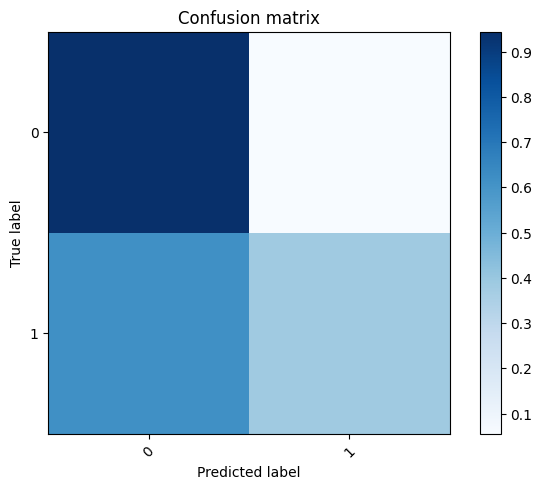

0.7623363544813696 ABCMeta {'n_estimators': 30}


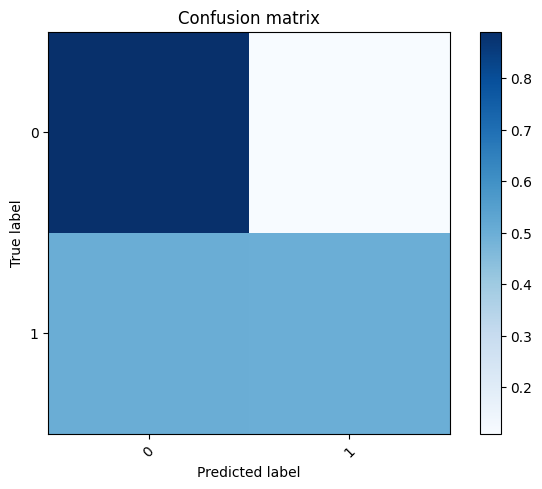

0.7628398791540786 type {'penalty': 'l2', 'solver': 'sag'}


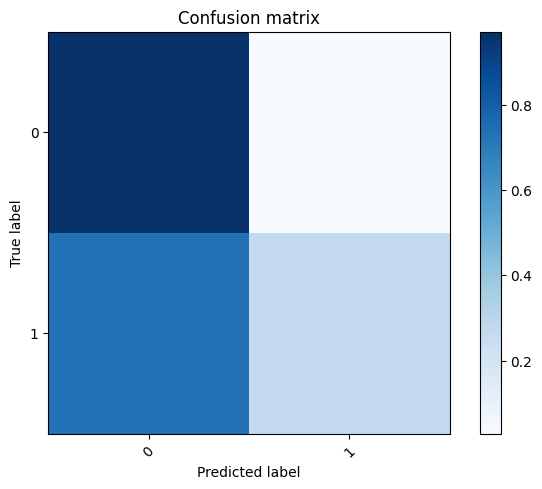

0.7429506545820745 ABCMeta {'alpha': 5, 'fit_prior': True}


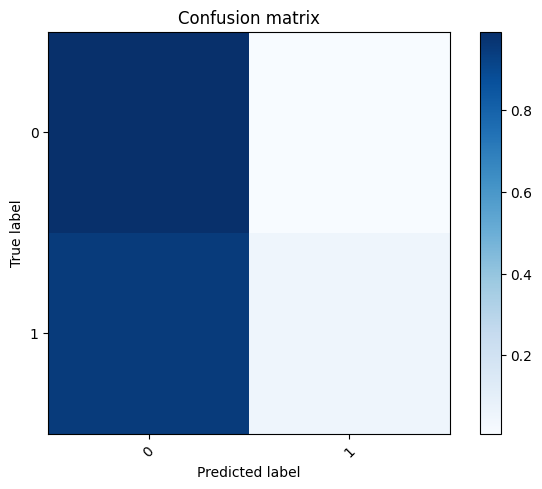

0.6865558912386707 ABCMeta {'n_neighbors': 5}


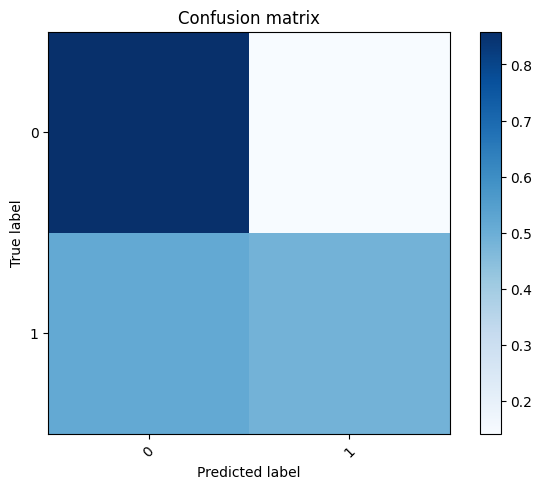

0.736404833836858 ABCMeta {'C': 10, 'kernel': 'rbf'}


[0.7623363544813696,
 0.7628398791540786,
 0.7429506545820745,
 0.6865558912386707,
 0.736404833836858]

In [ ]:
accs = []
for i,clf in enumerate(classifiers):
  acc = clf.test_and_plot(tst_vecs[i],tst_labels,class_num=2)
  print(acc,clf.classifier.__class__.__name__,clf.params)
  accs.append(acc)
  
accs

## Subtask B

### Reading data and splitting

In [ ]:
dr_b = DataReader('/content/drive/MyDrive/datasets/training-v1/offenseval-training-v1.tsv','B')
data_b,labels_b = dr_b.get_labelled_data()
data_b,labels_b = dr_b.shuffle(data_b,labels_b,'random')

tr_data_b,tst_data_b,tr_labels_b,tst_labels_b = split(data_b,labels_b,test_size=0.3)

Reading Data: 13241it [00:00, 99111.41it/s] 


### Initializing objects

In [ ]:
preprocessors_b = [('lemmatize'),('remove_stopwords','lemmatize'),
        ('remove_stopwords','stem'),('remove_stopwords','lemmatize'),
        ('remove_stopwords','lemmatize'),('remove_stopwords')]

vectorizers_b = ['count','count','count','tfidf','glove']

classifiers_b = [('RandomForest',{'n_estimators':30}),
               ('LogisticRegression',{'penalty':'l2','solver':'sag'}),
              ('M-NaiveBayes',{'alpha':5,'fit_prior':True}),
              ('KNN',{'n_neighbors':5}),('SVC',{'C':10,'kernel':'rbf'})]

for i in range(len(vectorizers_b)):
  preprocessors_b[i] = Preprocessor(preprocessors_b[i])
  vectorizers_b[i] = Vectorizer(vectorizers_b[i])
  classifiers_b[i] = Classifier(*classifiers_b[i])

### Training classifiers

In [ ]:
tst_vecs_b = []
tr_vecs_b = []
for i in range(len(classifiers_b)):
  tr_data_clean_b = preprocessors_b[i].clean(tr_data_b)
  tst_data_clean_b = preprocessors_b[i].clean(tst_data_b)
  
  tr_vecs_b.append(vectorizers_b[i].vectorize(tr_data_clean_b))
  tst_vecs_b.append(vectorizers_b[i].vectorize(tst_data_clean_b))
  
  classifiers_b[i].fit(tr_vecs_b[i],tr_labels_b)

Preprocessing:   0%|          | 0/2 [00:00<?, ?it/s]
Tokenization: 0it [00:00, ?it/s]
Tokenization: 202it [00:00, 2016.21it/s]
Tokenization: 404it [00:00, 1897.73it/s]
Tokenization: 595it [00:00, 1803.18it/s]
Tokenization: 776it [00:00, 1786.52it/s]
Tokenization: 955it [00:00, 1731.04it/s]
Tokenization: 1131it [00:00, 1739.89it/s]
Tokenization: 1331it [00:00, 1820.69it/s]
Tokenization: 1528it [00:00, 1866.77it/s]
Tokenization: 1716it [00:00, 1838.73it/s]
Tokenization: 1901it [00:01, 1826.43it/s]
Tokenization: 2103it [00:01, 1882.70it/s]
Tokenization: 2292it [00:01, 1855.14it/s]
Tokenization: 2508it [00:01, 1942.85it/s]
Tokenization: 2711it [00:01, 1968.64it/s]
Tokenization: 3080it [00:01, 1929.38it/s]
Preprocessing:  50%|█████     | 1/2 [00:01<00:01,  1.61s/it]
Lemmatization: 0it [00:00, ?it/s]
Lemmatization: 22it [00:00, 207.94it/s]
Lemmatization: 46it [00:00, 218.77it/s]
Lemmatization: 68it [00:00, 214.94it/s]
Lemmatization: 91it [00:00, 218.92it/s]
Lemmatization: 121it [00:00, 246.3


Loading Glove Embeddings from api...


Finalizing: 100%|██████████| 3080/3080 [00:02<00:00, 1376.11it/s]



Loading Glove Embeddings from api...


Finalizing: 100%|██████████| 1320/1320 [00:00<00:00, 2360.60it/s]


### Testing and plotting

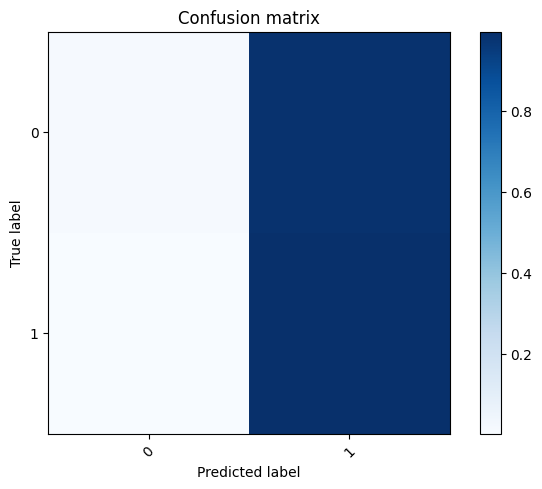

0.8742424242424243 RandomForestClassifier {'n_estimators': 30}


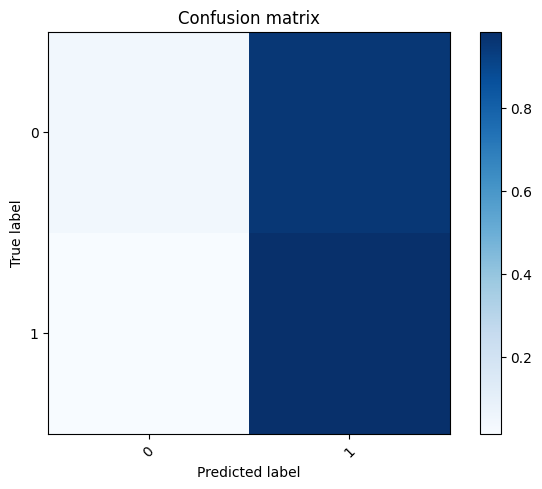

0.8681818181818182 LogisticRegression {'penalty': 'l2', 'solver': 'sag'}


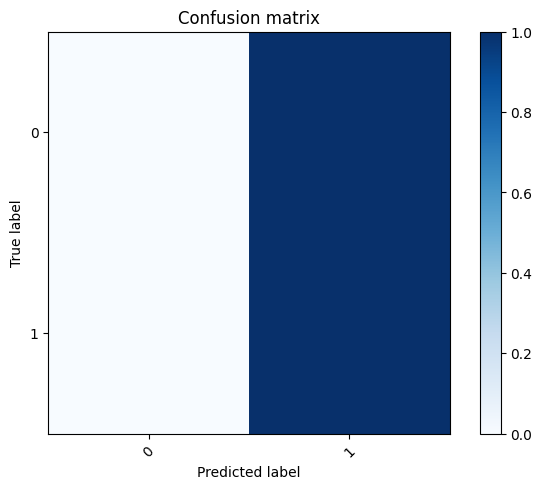

0.8765151515151515 MultinomialNB {'alpha': 5, 'fit_prior': True}


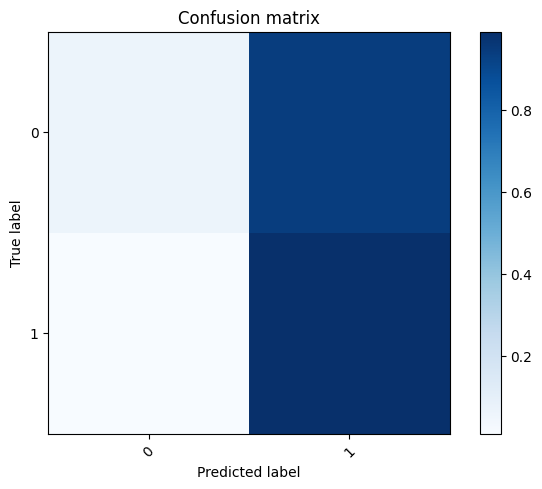

0.8757575757575757 KNeighborsClassifier {'n_neighbors': 5}


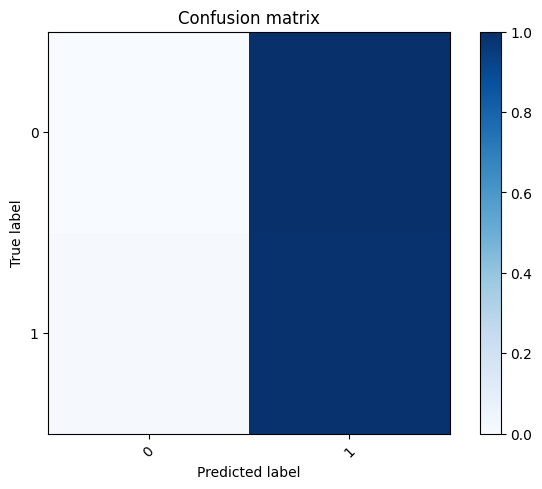

0.8681818181818182 SVC {'C': 10, 'kernel': 'rbf'}


[0.8742424242424243,
 0.8681818181818182,
 0.8765151515151515,
 0.8757575757575757,
 0.8681818181818182]

In [ ]:
accs_b = []
for i,clf in enumerate(classifiers_b):
  acc = clf.test_and_plot(tst_vecs_b[i],tst_labels_b,class_num=2)
  print(acc,clf.classifier.__name__,clf.params)
  accs_b.append(acc)
  
accs_b

## Subtask C

### Reading data and splitting

In [ ]:
dr_c = DataReader('/content/drive/MyDrive/datasets/training-v1/offenseval-training-v1.tsv','C')
data_c,labels_c = dr_c.get_labelled_data()
data_c,labels_c = dr_c.shuffle(data_c,labels_c,'random')

tr_data_c,tst_data_c,tr_labels_c,tst_labels_c = split(data_c,labels_c,test_size=0.3)

Reading Data: 13241it [00:00, 200932.65it/s]


### Initializing objects

In [ ]:
preprocessors_c = [('lemmatize'),('remove_stopwords','lemmatize'),
        ('remove_stopwords','stem'),('remove_stopwords','lemmatize'),
        ('remove_stopwords','lemmatize'),('remove_stopwords')]

vectorizers_c = ['count','count','count','tfidf','glove']

classifiers_c = [('RandomForest',{'n_estimators':30}),
               ('LogisticRegression',{'penalty':'l2','solver':'sag'}),
              ('M-NaiveBayes',{'alpha':5,'fit_prior':True}),
              ('KNN',{'n_neighbors':5}),('SVC',{'C':10,'kernel':'rbf'})]

for i in range(len(vectorizers_c)):
  preprocessors_c[i] = Preprocessor(preprocessors_c[i])
  vectorizers_c[i] = Vectorizer(vectorizers_c[i])
  classifiers_c[i] = Classifier(*classifiers_c[i])

### Training classifiers

In [ ]:
tst_vecs_c = []
tr_vecs_c = []
for i in range(len(classifiers_c)):
  tr_data_clean_c = preprocessors_c[i].clean(tr_data_c)
  tst_data_clean_c = preprocessors_c[i].clean(tst_data_c)
  
  tr_vecs_c.append(vectorizers_c[i].vectorize(tr_data_clean_c))
  tst_vecs_c.append(vectorizers_c[i].vectorize(tst_data_clean_c))
  
  classifiers_c[i].fit(tr_vecs_c[i],tr_labels_c)

Preprocessing:   0%|          | 0/2 [00:00<?, ?it/s]
Tokenization: 0it [00:00, ?it/s]
Tokenization: 332it [00:00, 3314.50it/s]
Tokenization: 664it [00:00, 3116.34it/s]
Tokenization: 1007it [00:00, 3251.96it/s]
Tokenization: 1334it [00:00, 2531.55it/s]
Tokenization: 1606it [00:00, 2344.29it/s]
Tokenization: 1853it [00:00, 2201.00it/s]
Tokenization: 2081it [00:00, 2115.00it/s]
Tokenization: 2298it [00:00, 2024.67it/s]
Tokenization: 2504it [00:01, 2028.20it/s]
Tokenization: 2713it [00:01, 2255.19it/s]
Preprocessing:  50%|█████     | 1/2 [00:01<00:01,  1.21s/it]
Lemmatization: 0it [00:00, ?it/s]
Lemmatization: 14it [00:00, 133.57it/s]
Lemmatization: 28it [00:00, 126.80it/s]
Lemmatization: 43it [00:00, 136.06it/s]
Lemmatization: 57it [00:00, 130.63it/s]
Lemmatization: 71it [00:00, 126.24it/s]
Lemmatization: 84it [00:00, 122.75it/s]
Lemmatization: 99it [00:00, 129.74it/s]
Lemmatization: 114it [00:00, 134.87it/s]
Lemmatization: 128it [00:00, 132.70it/s]
Lemmatization: 142it [00:01, 131.83it/s


Loading Glove Embeddings from api...


Finalizing: 100%|██████████| 2713/2713 [00:02<00:00, 1171.15it/s]



Loading Glove Embeddings from api...


Finalizing: 100%|██████████| 1163/1163 [00:00<00:00, 2399.45it/s]


### Testing and plotting

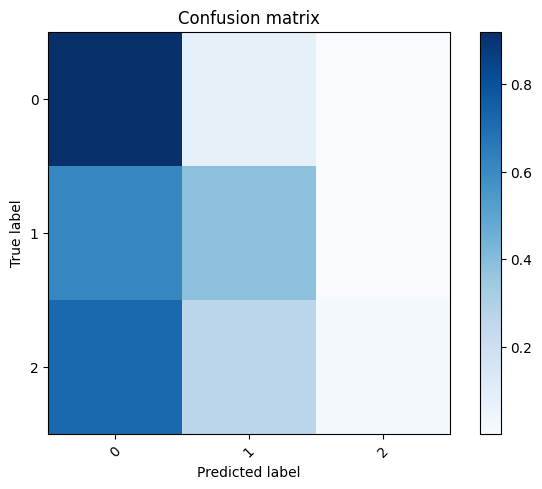

0.6775580395528805 RandomForestClassifier {'n_estimators': 30}


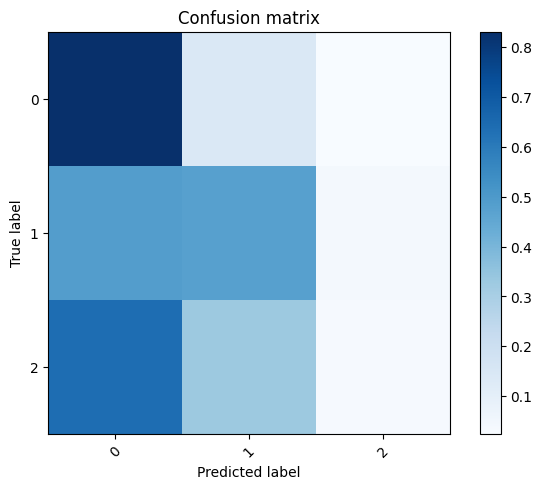

0.650042992261393 LogisticRegression {'penalty': 'l2', 'solver': 'sag'}


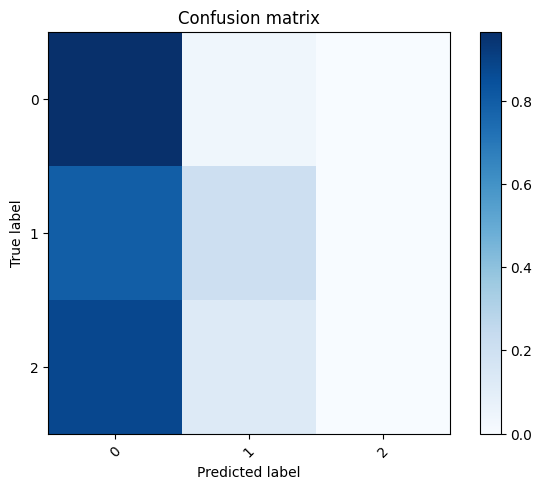

0.6560619088564058 MultinomialNB {'alpha': 5, 'fit_prior': True}


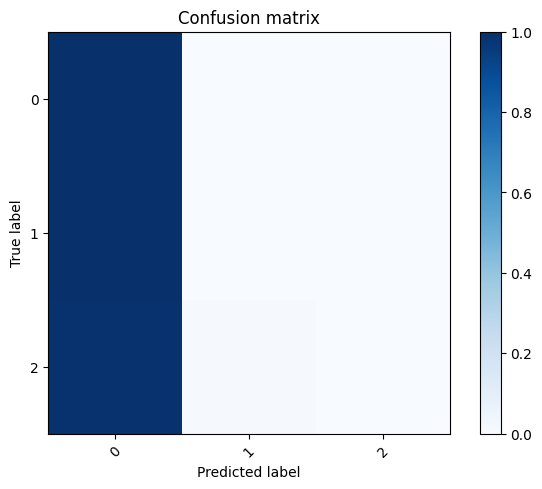

0.6199484092863284 KNeighborsClassifier {'n_neighbors': 5}


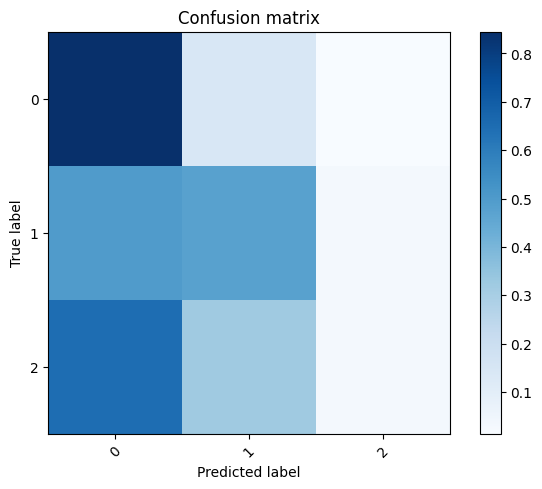

0.6586414445399829 SVC {'C': 10, 'kernel': 'rbf'}


[0.6775580395528805,
 0.650042992261393,
 0.6560619088564058,
 0.6199484092863284,
 0.6586414445399829]

In [ ]:
accs_c = []
for i,clf in enumerate(classifiers_c):
  acc = clf.test_and_plot(tst_vecs_c[i],tst_labels_c,class_num=3)
  print(acc,clf.classifier.__name__,clf.params)
  accs_c.append(acc)
  
accs_c

#Using LSTM

## Subtask A

### Reading data and cleaning

In [ ]:
dr_nn = DataReader('/content/drive/MyDrive/datasets/training-v1/offenseval-training-v1.tsv','A')
data_nn,labels_nn = dr_nn.get_labelled_data()
data_nn,labels_nn = dr_nn.shuffle(data_nn,labels_nn,'random')

tr_data_nn,tst_data_nn,tr_labels_nn,tst_labels_nn = split(data_nn,labels_nn,test_size=0.3)

prp = Preprocessor('remove_stopwords','lemmatize')
tr_data_clean_nn = prp.clean(tr_data_nn)
tst_data_clean_nn = prp.clean(tst_data_nn)

vct = Vectorizer('count')
vct.vectorize(tr_data_clean_nn)

Reading Data: 13241it [00:00, 203321.20it/s]
Preprocessing:   0%|          | 0/3 [00:00<?, ?it/s]
Tokenization: 0it [00:00, ?it/s]
Tokenization: 397it [00:00, 3964.56it/s]
Tokenization: 794it [00:00, 3853.74it/s]
Tokenization: 1180it [00:00, 3774.54it/s]
Tokenization: 1558it [00:00, 3678.82it/s]
Tokenization: 1927it [00:00, 3671.51it/s]
Tokenization: 2309it [00:00, 3720.36it/s]
Tokenization: 2682it [00:00, 3696.07it/s]
Tokenization: 3066it [00:00, 3740.22it/s]
Tokenization: 3441it [00:00, 3694.75it/s]
Tokenization: 3811it [00:01, 3676.93it/s]
Tokenization: 4200it [00:01, 3740.01it/s]
Tokenization: 4575it [00:01, 3708.32it/s]
Tokenization: 4960it [00:01, 3746.30it/s]
Tokenization: 5335it [00:01, 3703.08it/s]
Tokenization: 5718it [00:01, 3739.58it/s]
Tokenization: 6093it [00:01, 3677.14it/s]
Tokenization: 6508it [00:01, 3814.95it/s]
Tokenization: 6890it [00:01, 3754.66it/s]
Tokenization: 7266it [00:01, 3561.44it/s]
Tokenization: 7663it [00:02, 3675.92it/s]
Tokenization: 8033it [00:02, 36

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### Training LSTM

In [ ]:
lstm = DeepLearner(tr_data_clean_nn,tr_labels_nn,vocab_length=vct.vocab_length,model_type='LSTM')
lstm.train(epochs=60)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 41, 30)            387450    
                                                                 
 lstm_3 (LSTM)               (None, 200)               184800    
                                                                 
 dense_1 (Dense)             (None, 41)                8241      
                                                                 
 dense_2 (Dense)             (None, 2)                 84        
                                                                 
Total params: 580,575
Trainable params: 580,575
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
95/95 [==============================] - 35s 269ms/step - loss: 27.8815 - accuracy: 0.6655 - val_loss: 8.1539 - val_accuracy: 0.6779
Epoch 2/60
95/95 [==================

### Testing LSTM and plotting

63/63 [==============================] - 3s 40ms/step


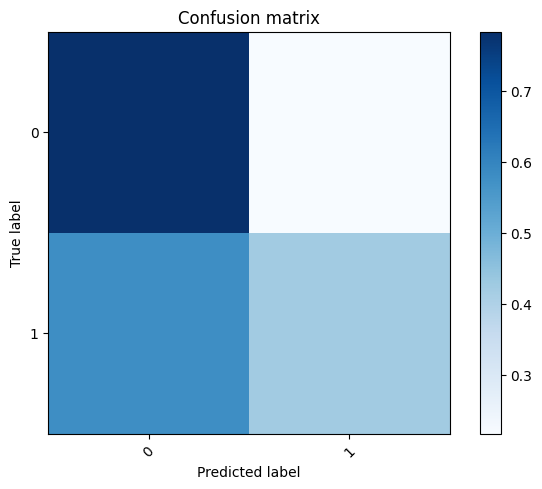

63/63 [==============================] - 3s 40ms/step - loss: 0.6925 - accuracy: 0.6636
LSTM (['loss', 'accuracy'], [0.6925440430641174, 0.6636455059051514])


In [ ]:
acc = lstm.test_and_plot(tst_data_clean_nn,tst_labels_nn)
print('LSTM',acc)

## Subtask B

### Reading data and cleaning

In [ ]:
dr_nn_b = DataReader('/content/drive/MyDrive/datasets/training-v1/offenseval-training-v1.tsv','B')
data_nn_b,labels_nn_b = dr_nn_b.get_labelled_data()
data_nn_b,labels_nn_b = dr_nn_b.shuffle(data_nn_b,labels_nn_b,'random')

tr_data_nn_b,tst_data_nn_b,tr_labels_nn_b,tst_labels_nn_b = split(data_nn_b,labels_nn_b,test_size=0.3)

prp = Preprocessor('remove_stopwords','lemmatize')
tr_data_clean_nn_b = prp.clean(tr_data_nn_b)
tst_data_clean_nn_b = prp.clean(tst_data_nn_b)

vct = Vectorizer('count')
vct.vectorize(tr_data_clean_nn_b)

Reading Data: 13241it [00:00, 193355.68it/s]
Preprocessing:   0%|          | 0/3 [00:00<?, ?it/s]
Tokenization: 0it [00:00, ?it/s]
Tokenization: 356it [00:00, 3551.50it/s]
Tokenization: 712it [00:00, 3155.26it/s]
Tokenization: 1031it [00:00, 3151.99it/s]
Tokenization: 1402it [00:00, 3362.29it/s]
Tokenization: 1741it [00:00, 3300.36it/s]
Tokenization: 2103it [00:00, 3401.24it/s]
Tokenization: 2447it [00:00, 3413.40it/s]
Tokenization: 3080it [00:00, 3299.14it/s]
Preprocessing:  33%|███▎      | 1/3 [00:00<00:01,  1.06it/s]
Stopwords Removal: 3080it [00:00, 53649.86it/s]

Lemmatization: 0it [00:00, ?it/s]
Lemmatization: 46it [00:00, 443.27it/s]
Lemmatization: 105it [00:00, 525.20it/s]
Lemmatization: 158it [00:00, 470.49it/s]
Lemmatization: 206it [00:00, 460.82it/s]
Lemmatization: 262it [00:00, 488.96it/s]
Lemmatization: 316it [00:00, 504.05it/s]
Lemmatization: 367it [00:00, 479.75it/s]
Lemmatization: 423it [00:00, 503.52it/s]
Lemmatization: 474it [00:00, 489.94it/s]
Lemmatization: 524it [0

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### Training LSTM

In [ ]:
lstm_b = DeepLearner(tr_data_clean_nn_b,tr_labels_nn_b,vocab_length=vct.vocab_length,model_type='LSTM')
lstm_b.train(epochs=60)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 41, 30)            208860    
                                                                 
 lstm_4 (LSTM)               (None, 200)               184800    
                                                                 
 dense_3 (Dense)             (None, 41)                8241      
                                                                 
 dense_4 (Dense)             (None, 2)                 84        
                                                                 
Total params: 401,985
Trainable params: 401,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
32/32 [==============================] - 9s 198ms/step - loss: 46.9301 - accuracy: 0.8531 - val_loss: 32.5989 - val_accuracy: 0.8822
Epoch 2/60
32/32 [==================

### Testing LSTM and plotting

21/21 [==============================] - 1s 39ms/step


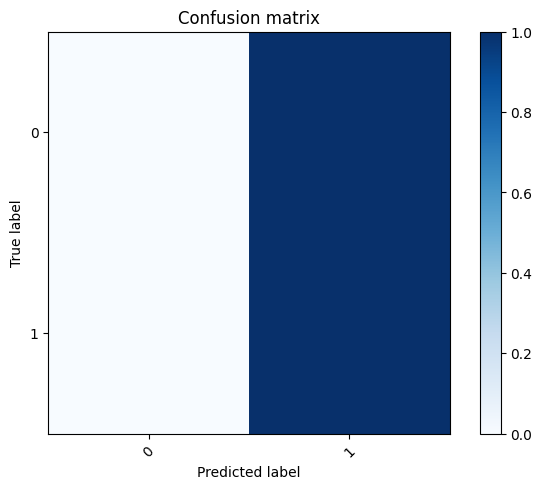

21/21 [==============================] - 1s 39ms/step - loss: 0.3752 - accuracy: 0.8780
LSTM (['loss', 'accuracy'], [0.37520861625671387, 0.8780303001403809])


In [ ]:
acc = lstm_b.test_and_plot(tst_data_clean_nn_b,tst_labels_nn_b)
print('LSTM',acc)

## Subtask C

### Reading data and cleaning

In [ ]:
dr_nn_c = DataReader('/content/drive/MyDrive/datasets/training-v1/offenseval-training-v1.tsv','C')
data_nn_c,labels_nn_c = dr_nn_c.get_labelled_data()
data_nn_c,labels_nn_c = dr_nn_c.shuffle(data_nn_c,labels_nn_c,'random')

tr_data_nn_c,tst_data_nn_c,tr_labels_nn_c,tst_labels_nn_c = split(data_nn_c,labels_nn_c,test_size=0.3)

prp = Preprocessor('remove_stopwords','lemmatize')
tr_data_clean_nn_c = prp.clean(tr_data_nn_c)
tst_data_clean_nn_c = prp.clean(tst_data_nn_c)

vct = Vectorizer('count')
vct.vectorize(tr_data_clean_nn_c)

Reading Data: 13241it [00:00, 198189.21it/s]
Preprocessing:   0%|          | 0/3 [00:00<?, ?it/s]
Tokenization: 0it [00:00, ?it/s]
Tokenization: 316it [00:00, 3154.93it/s]
Tokenization: 673it [00:00, 3397.94it/s]
Tokenization: 1013it [00:00, 3317.90it/s]
Tokenization: 1346it [00:00, 3141.03it/s]
Tokenization: 1662it [00:00, 3102.38it/s]
Tokenization: 2009it [00:00, 3221.09it/s]
Tokenization: 2333it [00:00, 3168.75it/s]
Tokenization: 2713it [00:00, 3141.00it/s]
Preprocessing:  33%|███▎      | 1/3 [00:00<00:01,  1.15it/s]
Stopwords Removal: 2713it [00:00, 48909.54it/s]

Lemmatization: 0it [00:00, ?it/s]
Lemmatization: 52it [00:00, 516.82it/s]
Lemmatization: 109it [00:00, 545.18it/s]
Lemmatization: 164it [00:00, 541.75it/s]
Lemmatization: 219it [00:00, 527.28it/s]
Lemmatization: 272it [00:00, 523.88it/s]
Lemmatization: 325it [00:00, 499.75it/s]
Lemmatization: 376it [00:00, 488.40it/s]
Lemmatization: 425it [00:00, 482.83it/s]
Lemmatization: 487it [00:00, 519.51it/s]
Lemmatization: 540it [0

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### Training LSTM

In [ ]:
lstm_c = DeepLearner(tr_data_clean_nn_c,tr_labels_nn_c,vocab_length=vct.vocab_length,model_type='LSTM')
lstm_c.train(epochs=60)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 41, 30)            195360    
                                                                 
 lstm_5 (LSTM)               (None, 200)               184800    
                                                                 
 dense_5 (Dense)             (None, 41)                8241      
                                                                 
 dense_6 (Dense)             (None, 3)                 126       
                                                                 
Total params: 388,527
Trainable params: 388,527
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
28/28 [==============================] - 8s 186ms/step - loss: 48.7585 - accuracy: 0.6047 - val_loss: 35.7080 - val_accuracy: 0.6200
Epoch 2/60
28/28 [==================

### Testing LSTM and plotting

19/19 [==============================] - 1s 39ms/step


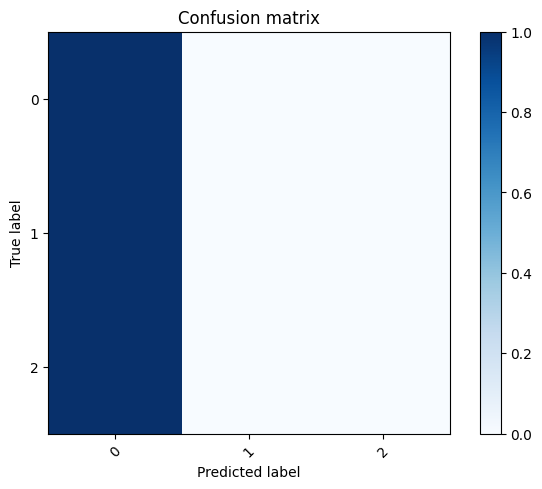

19/19 [==============================] - 1s 42ms/step - loss: 0.9287 - accuracy: 0.6234
LSTM (['loss', 'accuracy'], [0.9287267923355103, 0.6233878135681152])


In [ ]:
acc = lstm_c.test_and_plot(tst_data_clean_nn_c,tst_labels_nn_c,3)
print('LSTM',acc)